In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn import preprocessing
import time
from datetime import date, datetime

today = datetime.today()
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.max_rows = 200

In [2]:
#TODO: Remove unused packages

# Coding Challenge
## Objective: improve performance
### Benchmark: https://triamus.github.io/project/lending-club-loan-data-in-r/#loan-amount-and-income

Some steps with preprocessing data was skipped, due to time constraint. The project is mainly supposed to show the improvement of the performance

# Prepare Data

In [3]:
dt = pd.read_csv("loan.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# drop columns that containt all nans
data = dt.dropna(axis=1, how='all')

In [5]:
d_variable = [
    "emp_title","title" ,"desc", "verification_status_joint", "next_pymnt_d","hardship_status",
    "sub_grade","policy_code","zip_code","addr_state","sec_app_earliest_cr_line", "settlement_term",
    "settlement_status", "settlement_date", "settlement_amount","settlement_percentage",
    "debt_settlement_flag_date", "debt_settlement_flag","disbursement_method","hardship_dpd",
    "hardship_loan_status", "hardship_dpd","payment_plan_start_date",
    "mths_since_recent_bc","mths_since_recent_bc_dlq","mths_since_recent_inq","mths_since_recent_revol_delinq",
    "mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op","mo_sin_rcnt_tl",
    "pct_tl_nvr_dlq","tot_hi_cred_lim","total_bal_ex_mort","total_bc_limit",
    "total_il_high_credit_limit","last_pymnt_d","issue_d"
]


In [6]:
data = data.drop(d_variable, axis=1)

# Short Explanation on removing some variables

1. too many distinct values, creating dummy variables will be too expensive<br>
emp_title<br>
title
2. Text data might be interesting but NLP is out of scope for this project. Processing too time consuming, leave out for this analysis.<br>
desc
2. also might tell us something (for example, some states might have some systematic risk) it will require to create 50 dummies. For ZIP Code it would require even more Computationally too expensive. The computer I'm using already hardly copes with current data dimension<br>
addr_state<br>
zip_code
3. since it's not live data, it would be biased<br>
last_pymnt_d<br>
last_pymnt_amnt<br>
settlement_term<br>
settlement_status<br>
settlement_date<br>
settlement_amount<br>
settlement_percentage
4. redundant, information contained in other variables<br>
hardship_status
5. not enough information to use data once could for example calcualte the lenght of the settlement. In the active settlements, we can use current data but for  there is no information on enddate for COMPLETE and BROKEN<br>
settlement_term<br>
settlement_status<br>
settlement_date<br>
settlement_amount<br>
settlement_percentage
6. Hard to handle missing values without imputing method, further I will impute most data with 0, which is not optimal in the case of some variables. Missing days since last deliquincies might say that there was none of them. Imputing 0 will bias data.
mths_since_recent_bc<br>
mths_since_recent_bc_dlq<br>
mths_since_recent_inq<br>
mths_since_recent_revol_delinq<br>
mo_sin_old_il_acct<br>
mo_sin_old_rev_tl_op<br>
mo_sin_rcnt_rev_tl_op<br>
mo_sin_rcnt_tl<br>
pct_tl_nvr_dlq<br>
percent_bc_gt_75<br>
tot_hi_cred_lim<br>
total_bal_ex_mort<br>
total_bc_limit<br>
total_il_high_credit_limit<br>



In [7]:
# Since we are interested in default and non-default, current loans arent going to help us with prediction.
# the would be great observations of out of sample testing
data = data.loc[data["loan_status"]!="Current"]

In [8]:
data["earliest_cr_line"] = pd.to_datetime(data["earliest_cr_line"])
#data["issue_d"] = pd.to_datetime(data["issue_d"])
data["hardship_start_date"] = pd.to_datetime(data["hardship_start_date"],errors = 'coerce')
data["hardship_end_date"] = pd.to_datetime(data["hardship_end_date"],errors = 'coerce')
data["last_credit_pull_d"] = pd.to_datetime(data["last_credit_pull_d"],errors = 'coerce')


In [9]:
# already looked at data. if hardship_start_date exists then hardship_end_date also does

In [10]:
initial_listing = pd.get_dummies(data["initial_list_status"])
data = data.merge(initial_listing, left_index=True, right_index=True)
data = data.drop("initial_list_status", axis=1)

In [11]:
hardship_type = pd.get_dummies(data["hardship_type"])
data["hardship_type"] = data["hardship_type"].replace(np.nan,"No Hardship")
data = data.merge(hardship_type, left_index=True, right_index=True)
data = data.drop("hardship_type", axis=1)

In [12]:
verification = pd.get_dummies(data["verification_status"])
data = data.merge(verification, left_index=True, right_index=True)
data = data.drop("verification_status", axis=1)

In [13]:
data['harship_len'] = (data['hardship_end_date'] - data['hardship_start_date'])
data['harship_len'] = data['harship_len'].apply(lambda x: x.days)
data['harship_len'] = data['harship_len'].replace(np.nan,0)
data = data.drop("hardship_end_date", axis=1)
data = data.drop("hardship_start_date", axis=1)


In [14]:
data["last_credit_pull_d"] = (pd.Timestamp(today) - data["last_credit_pull_d"])
data['last_credit_pull_d'] = data['last_credit_pull_d'].apply(lambda x: x.days)
data['last_credit_pull_d'] = data['last_credit_pull_d'].replace(np.nan,0)


In [15]:
data["earliest_cr_line"] = (pd.Timestamp(today) - data["earliest_cr_line"])
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda x: x.days)
data['earliest_cr_line'] = data['earliest_cr_line'].replace(np.nan,0)


In [16]:

term = {' 36 months': 1,' 60 months': 0}
data.term = [term[item] for item in data.term]

data["term"].unique()

array([1, 0])

In [17]:
grade = {
    'A' : 7, 'B' : 6, 'C' : 5,
    'D' : 4, 'E' : 3, 'F' : 2,
    'G' : 1,
}

data.grade = [grade[item] for item in data.grade]

data["grade"].unique()

array([4, 5, 7, 6, 3, 1, 2])

In [18]:
purpose_dummies = pd.get_dummies(data["purpose"])
data = data.merge(purpose_dummies, left_index=True, right_index=True)
data = data.drop("purpose", axis=1)

In [19]:
employment = {
    '10+ years' : 11, '6 years' : 7, 
    '4 years' : 5, '< 1 year' : 1, 
    '2 years' : 3, '9 years' : 10,
    np.nan : 0, '5 years' : 6,
    '3 years' : 4, '7 years' : 8,
    '1 year' : 2,'8 years' : 9
             }

data.emp_length = [employment[item] for item in data.emp_length]
data["emp_length"].unique()

array([ 6,  1, 11,  4,  5,  2,  9,  0,  3,  7, 10,  8])

In [20]:

plan = {'y': 1,'n': 0}
data.pymnt_plan = [plan[item] for item in data.pymnt_plan]

data["pymnt_plan"].unique()
data["hardship_length"] = data["hardship_length"].replace(np.nan,0)

In [21]:
application = {'Individual': 1,'Joint App': 0}
data.application_type = [application[item] for item in data.application_type]

data["application_type"].unique()

array([0, 1])

In [22]:
home_dummies = pd.get_dummies(data["home_ownership"])
data = data.merge(home_dummies, left_index=True, right_index=True)
data = data.drop("home_ownership", axis = 1)

In [23]:
# 0: not default
# 1: default
default = {
    'Current' : 0, 'Fully Paid' : 0 ,
    'Late (31-120 days)' : 1, 'In Grace Period':1,
    'Charged Off' : 1, 'Late (16-30 days)':1,
    'Default' : 1, 'Does not meet the credit policy. Status:Fully Paid' : 0,
    'Does not meet the credit policy. Status:Charged Off' : 1
}

data.loan_status = [default[item] for item in data.loan_status]

In [24]:
# looking the outliars closely, remove few examples with absurdly high income
data = (data.loc[data["annual_inc"]<10000000])

In [25]:
# normalize some skewed data
data["annual_inc"] = np.log(data["annual_inc"])
data["annual_inc"] = data["annual_inc"].replace(float('-inf'),0)

data["total_pymnt_inv"] = np.log(data["total_pymnt_inv"])
data["total_pymnt_inv"] = data["total_pymnt_inv"].replace(float('-inf'),0)


data["total_pymnt"] = np.log(data["total_pymnt"])
data["total_pymnt"] = data["total_pymnt"].replace(float('-inf'),0)


data["installment"] = np.log(data["installment"])
data["installment"] = data["installment"].replace(float('-inf'),0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [26]:
data["hardship_reason"] = data["hardship_reason"].replace(np.nan,'NO_HARDSHIP')
hardship_reason = pd.get_dummies(data["hardship_reason"])
data = data.merge(hardship_reason, left_index=True, right_index=True)
data = data.drop("hardship_reason", axis=1)

In [27]:
hardship = {'Y': 1,'N': 0}
data.hardship_flag = [hardship[item] for item in data.hardship_flag]

# some visual

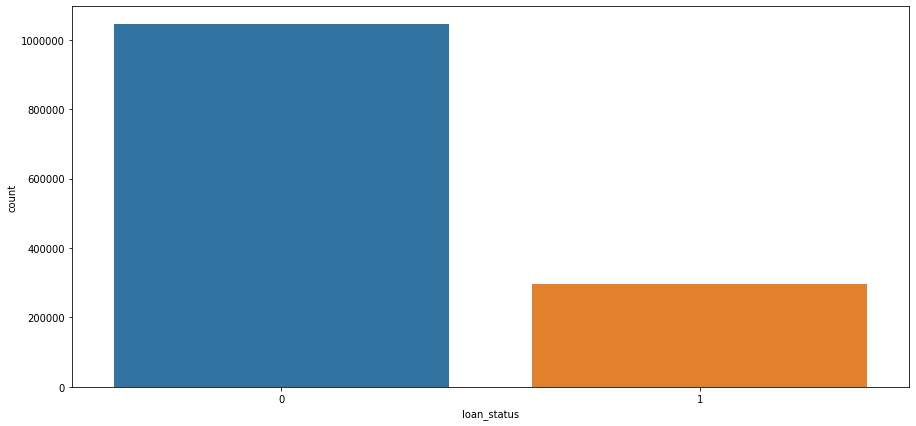

In [28]:
# outcome variable
plt.figure(figsize=(15,7))
ax = sns.countplot(x="loan_status", data=data)
plt.show()

In [29]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,loan_status,...,DISABILITY,DIVORCE,EXCESSIVE_OBLIGATIONS,FAMILY_DEATH,INCOME_CURTAILMENT,MEDICAL,NATURAL_DISASTER,NO_HARDSHIP,REDUCED_HOURS,UNEMPLOYMENT
100,30000,30000,30000.0,1,22.35,7.048525,4,6,11.512925,0,...,0,0,0,0,0,0,0,1,0,0
152,40000,40000,40000.0,0,16.14,6.883165,5,1,10.714418,0,...,0,0,0,0,0,0,0,1,0,0
170,20000,20000,20000.0,1,7.56,6.434033,7,11,11.512925,0,...,0,0,0,0,0,0,0,1,0,0
186,4500,4500,4500.0,1,11.31,4.997145,6,11,10.558414,0,...,0,0,0,0,0,0,0,1,0,0
215,8425,8425,8425.0,1,27.27,5.844066,3,4,13.017003,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
sns.pairplot(data=data, hue='loan_status')


# Replace NaNs
Idealy, I would spend some time on data imputation, to keep the distribution. Due to a time constraint, I will replace most of the values with 0. By looking at the variable it makes sense.

##### i could have just done data.replace(np.nan,0) but I wanted to provide some intuation of why they were set to 0. 

In [29]:
# if no joint, replace with non-joint value
data.revol_bal_joint.fillna(data.revol_bal, inplace=True)
data.annual_inc_joint.fillna(data.annual_inc, inplace=True)
data.dti_joint.fillna(data.dti, inplace=True)
data.annual_inc_joint.fillna(data.annual_inc, inplace=True)

In [30]:
# many nans from hardship occure due to the fact that these people were not in hardship
data[["hardship_amount", 
      "hardship_last_payment_amount",
      "hardship_last_payment_amount", 
      "orig_projected_additional_accrued_interest",
      "deferral_term",
      "hardship_payoff_balance_amount"]] = \
data[["hardship_amount", 
      "hardship_last_payment_amount",
      "hardship_last_payment_amount", 
      "orig_projected_additional_accrued_interest",
      "deferral_term",
      "hardship_payoff_balance_amount"]].replace(np.nan,0)

# if income is missing, I will assume that is safe to assume that the indivisual has no income
data["annual_inc"] = data["annual_inc"].replace(np.nan,0)
# dti is a ratio where in denominator there is income, by examining it closely due to income 0 we get nans.
# Assume again that it's safe to divide it by 0
data[["dti","il_util"]] = data[["dti","il_util"]].replace(np.nan,0)

# for the number of account its reasonable to say that maybe these people didnt have an account
# same logic for account balance or other credits
data[["open_acc",
      "total_acc",
      "acc_now_delinq",
      "tot_coll_amt",
      "tot_cur_bal",
      "open_acc_6m",
      "open_act_il",
      "acc_open_past_24mths",
      "avg_cur_bal",
      "bc_open_to_buy",
      "bc_util",
      "collections_12_mths_ex_med",
      "revol_bal",
      "revol_util",
      "open_il_12m",
      "open_il_24m",
      "mths_since_rcnt_il",
      "total_bal_il",
      "open_rv_12m",
      "open_rv_24m",
      "max_bal_bc",
      "all_util",
      "total_rev_hi_lim",
      "inq_fi",
      "total_cu_tl",
      "sec_app_inq_last_6mths",
      "sec_app_mort_acc",
      "sec_app_open_acc",
      "sec_app_revol_util",
      "sec_app_open_act_il",
      "sec_app_num_rev_accts",
      "sec_app_chargeoff_within_12_mths",
      "sec_app_collections_12_mths_ex_med",
      "sec_app_mths_since_last_major_derog",
      "num_accts_ever_120_pd",
      "num_actv_bc_tl",
      "num_actv_rev_tl",
      "num_bc_sats",
      "num_bc_tl",
      "num_il_tl",
      "num_op_rev_tl",
      "num_rev_accts",
      "num_rev_tl_bal_gt_0",
      "num_sats",
      "num_tl_120dpd_2m",
      "num_tl_30dpd",
      "num_tl_90g_dpd_24m",
      "num_tl_op_past_12m",
      "mort_acc"
]] = \
data[["open_acc",
      "total_acc",
      "acc_now_delinq",
      "tot_coll_amt",
      "tot_cur_bal",
      "open_acc_6m",
      "open_act_il",
      "acc_open_past_24mths",
      "avg_cur_bal",
      "bc_open_to_buy",
      "bc_util",
      "collections_12_mths_ex_med",
      "revol_bal",
      "revol_util",
      "open_il_12m",
      "open_il_24m",
      "mths_since_rcnt_il",
      "total_bal_il",
      "open_rv_12m",
      "open_rv_24m",
      "max_bal_bc",
      "all_util",
      "total_rev_hi_lim",
      "inq_fi",
      "total_cu_tl",
      "sec_app_inq_last_6mths",
      "sec_app_mort_acc",
      "sec_app_open_acc",
      "sec_app_revol_util",
      "sec_app_open_act_il",
      "sec_app_num_rev_accts",
      "sec_app_chargeoff_within_12_mths",
      "sec_app_collections_12_mths_ex_med",
      "sec_app_mths_since_last_major_derog",
      "num_accts_ever_120_pd",
      "num_actv_bc_tl",
      "num_actv_rev_tl",
      "num_bc_sats",
      "num_bc_tl",
      "num_il_tl",
      "num_op_rev_tl",
      "num_rev_accts",
      "num_rev_tl_bal_gt_0",
      "num_sats",
      "num_tl_120dpd_2m",
      "num_tl_30dpd",
      "num_tl_90g_dpd_24m",
      "num_tl_op_past_12m",
      "mort_acc"
     ]].replace(np.nan,0)


# similarly with any public or derogatory records, nan can mean that these people were not recorded
data[["delinq_2yrs",
      "delinq_amnt",
      "inq_last_6mths",
      "inq_last_12m",
      "pub_rec",
      "chargeoff_within_12_mths",
      "mths_since_last_delinq",
      "mths_since_last_record",
      "mths_since_last_major_derog",
      "pub_rec_bankruptcies",
      "tax_liens",
      "percent_bc_gt_75"]] = \
data[["delinq_2yrs",
      "delinq_amnt",
      "inq_last_6mths",
      "inq_last_12m",
      "pub_rec",
      "chargeoff_within_12_mths",
      "mths_since_last_delinq",
      "mths_since_last_record",
      "mths_since_last_major_derog",
      "pub_rec_bankruptcies",
      "tax_liens",
      "percent_bc_gt_75"]].replace(np.nan,0)

data[["total_pymnt_inv","total_pymnt"]] = data[["total_pymnt_inv","total_pymnt"]].replace([np.inf, -np.inf], np.nan)
data[["total_pymnt_inv","total_pymnt"]] = data[["total_pymnt_inv","total_pymnt"]].replace(np.nan,0)


# All data numeric

In [31]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340968 entries, 100 to 2260664
Data columns (total 134 columns):
loan_amnt                                     int64
funded_amnt                                   int64
funded_amnt_inv                               float64
term                                          int64
int_rate                                      float64
installment                                   float64
grade                                         int64
emp_length                                    int64
annual_inc                                    float64
loan_status                                   int64
pymnt_plan                                    int64
dti                                           float64
delinq_2yrs                                   float64
earliest_cr_line                              float64
inq_last_6mths                                float64
mths_since_last_delinq                        float64
mths_since_last_record            

# Missing Data Ratio

In [32]:
data.isnull().sum()/len(data)

loan_amnt                                     0.0
funded_amnt                                   0.0
funded_amnt_inv                               0.0
term                                          0.0
int_rate                                      0.0
installment                                   0.0
grade                                         0.0
emp_length                                    0.0
annual_inc                                    0.0
loan_status                                   0.0
pymnt_plan                                    0.0
dti                                           0.0
delinq_2yrs                                   0.0
earliest_cr_line                              0.0
inq_last_6mths                                0.0
mths_since_last_delinq                        0.0
mths_since_last_record                        0.0
open_acc                                      0.0
pub_rec                                       0.0
revol_bal                                     0.0


# Log normalize some data

In [42]:
#data.loc[(data["total_pymnt"].isnull()) | (data["total_pymnt_inv"].isnull())]

In [33]:
data["annual_inc"] = np.log(data["annual_inc"])
data["annual_inc"] = data["annual_inc"].replace(float('-inf'),0)

data["total_pymnt_inv"] = np.log(data["total_pymnt_inv"])
data["total_pymnt_inv"] = data["total_pymnt_inv"].replace(float('-inf'),0)

data["total_pymnt"] = np.log(data["total_pymnt"])
data["total_pymnt"] = data["total_pymnt"].replace(float('-inf'),0)

data["installment"] = np.log(data["installment"])
data["installment"] = data["installment"].replace(float('-inf'),0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [43]:
data[["total_pymnt","total_pymnt_inv"]] = data[["total_pymnt","total_pymnt_inv"]].replace([np.inf, -np.inf], np.nan)


In [44]:
header = np.array(data.columns)
all_data = data.values

# store arrays as npy file: mainly for speed


In [45]:
np.savez("data.npz", all_data, header)